# Notebook prepared following Moren's "Nuclear Models" 

https://github.com/mhjensenseminars/EducationalSeminars/tree/master/doc/pub/nuclearmodels/ipynb

## Liquid drop model as a simple parametrization of binding energies

A popular and physically intuitive model which can be used to parametrize 
the experimental binding energies as function of $A$, is the so-called 
the liquid drop model. The ansatz is based on the following expression

$$
BE(N,Z) = a_1A-a_2A^{2/3}-a_3\frac{Z^2}{A^{1/3}}-a_4\frac{(N-Z)^2}{A},
$$

where $A$ stands for the number of nucleons and the $a_i$s are parameters which are determined by a fit 
to the experimental data.




## Liquid drop model as a simple parametrization of binding energies
To arrive at the above expression we have assumed that:

 * There is a volume term $a_1A$ proportional with the number of nucleons (the energy is also an extensive quantity). When an assembly of nucleons of the same size is packed together into the smallest volume, each interior nucleon has a certain number of other nucleons in contact with it. This contribution is proportional to the volume.

 * There is a surface energy term $a_2A^{2/3}$. The assumption here is that a nucleon at the surface of a nucleus interacts with fewer other nucleons than one in the interior of the nucleus and hence its binding energy is less. This surface energy term takes that into account and is therefore negative and is proportional to the surface area.



## Liquid drop model as a simple parametrization of binding energies, continues

 * There is a Coulomb energy term $a_3\frac{Z^2}{A^{1/3}}$. The electric repulsion between each pair of protons in a nucleus yields less binding. 

 * There is an asymmetry term $a_4\frac{(N-Z)^2}{A}$. This term is associated with the Pauli exclusion principle and reflectd the fact that the proton-neutron interaction is more attractive on the average than the neutron-neutron and proton-proton interactions.



We could also add a so-called pairing term (an important model in nuclear physics), which is a correction term that
arises from the tendency of proton pairs and neutron pairs to
occur. An even number of particles is more stable than an odd number.





<!-- !split  -->
## Masses and Binding energies

The following python program reads now in the experimental data on binding energies and performs a least squares fit to the data using a Machine Learning library called **Scikit-Learn**.
Let us start with reading and organizing our data. 
We start with the compilation of masses and binding energies from 2016.
After having downloaded this file to our own computer, we are now ready to read the file and start structuring our data.


We start with preparing folders for storing our calculations and the data file over masses and binding energies. We import also various modules that we will find useful in order to present various Machine Learning methods. Here we focus mainly on the functionality of **Scikit-Learn**.

In [2]:
%matplotlib inline

# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("MassEval2016.dat"),'r')

Our next step is to read the data on experimental binding energies and
reorganize them as functions of the mass number $A$, the number of
protons $Z$ and neutrons $N$ using **pandas**.  Before we do this it is
always useful (unless you have a binary file or other types of compressed
data) to actually open the file and simply take a look at it!


In particular, the program that outputs the final nuclear masses is written in Fortran with a specific format. It means that we need to figure out the format and which columns contain the data we are interested in. Pandas comes with a function that reads formatted output. After having admired the file, we are now ready to start massaging it with **pandas**. The file begins with some basic format information.

"""                                                                                                                         
This is taken from the data file of the mass 2016 evaluation.                                                               
All files are 3436 lines long with 124 character per line.                                                                  
       Headers are 39 lines long.                                                                                           
   col 1     :  Fortran character control: 1 = page feed  0 = line feed                                                     
   format    :  a1,i3,i5,i5,i5,1x,a3,a4,1x,f13.5,f11.5,f11.3,f9.3,1x,a2,f11.3,f9.3,1x,i3,1x,f12.5,f11.5                     
   These formats are reflected in the pandas widths variable below, see the statement                                       
   widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),                                                            
   Pandas has also a variable header, with length 39 in this case.                                                          
"""

The data we are interested in are in columns 2, 3, 4 and 11, giving us
the number of neutrons, protons, mass numbers and binding energies,
respectively. We add also for the sake of completeness the element name. The data are in fixed-width formatted lines and we will
covert them into the **pandas** DataFrame structure.

In [3]:
# Read the experimental data with Pandas. 
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=35,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000

# Group the DataFrame by nucleon number, A.
#Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
#Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

We have now read in the data, grouped them according to the variables we are interested in. 
We see how easy it is to reorganize the data using **pandas**. If we
were to do these operations in C/C++ or Fortran, we would have had to
write various functions/subroutines which perform the above
reorganizations for us.  Having reorganized the data, we can now start
to make some simple fits using both the functionalities in **numpy** and
**Scikit-Learn** afterwards. 

Now we define five variables which contain
the number of nucleons $A$, the number of protons $Z$ and the number of neutrons $N$, the element name and finally the energies themselves.

In [4]:
A = Masses['A']
Z = Masses['Z']
N = Masses['N']
Element = Masses['Element']
Energies = Masses['Ebinding']
print(Masses)

        N    Z    A Element  Ebinding
0       1    2    3      He  2.572680
2       3    1    4       H  1.720449
3       2    2    4      He  7.073915
4       1    3    4      Li  1.153760
5       4    1    5       H  1.336359
...   ...  ...  ...     ...       ...
3301  156  108  264      Hs  7.298375
3307  157  108  265      Hs  7.296247
3314  158  108  266      Hs  7.298273
3335  159  110  269      Ds  7.250154
3341  160  110  270      Ds  7.253775

[2494 rows x 5 columns]


In [5]:
Masses

,N,Z,A,Element,Ebinding
0,1,2,3,He,2.572680
2,3,1,4,H,1.720449
3,2,2,4,He,7.073915
4,1,3,4,Li,1.153760
5,4,1,5,H,1.336359
...,...,...,...,...,...
3301,156,108,264,Hs,7.298375
3307,157,108,265,Hs,7.296247
3314,158,108,266,Hs,7.298273
3335,159,110,269,Ds,7.250154


The next step is to set up the so-called **design matrix**. We will throughout call this matrix $\boldsymbol{X}$.
It has dimensionality $p\times n$, where $n$ is the number of data points and $p$ are the so-called predictors. In our case here they are given by the number of polynomials in $A$ we wish to include in the fit.

In [6]:
# Now we set up the design matrix X, since the table has binding energy per nucleon we divide by A
X = np.zeros((len(A),4))
X[:,0] = A/A
X[:,1] = -A**(2.0/3.0)/A
X[:,2] = -(Z**2)*(A**(-1.0/3.0))/A
X[:,3] = -((N-Z)**2)*A**(-1.0)/A

In [7]:
clf = skl.LinearRegression(fit_intercept=False).fit(X, Energies)
fity = clf.predict(X)

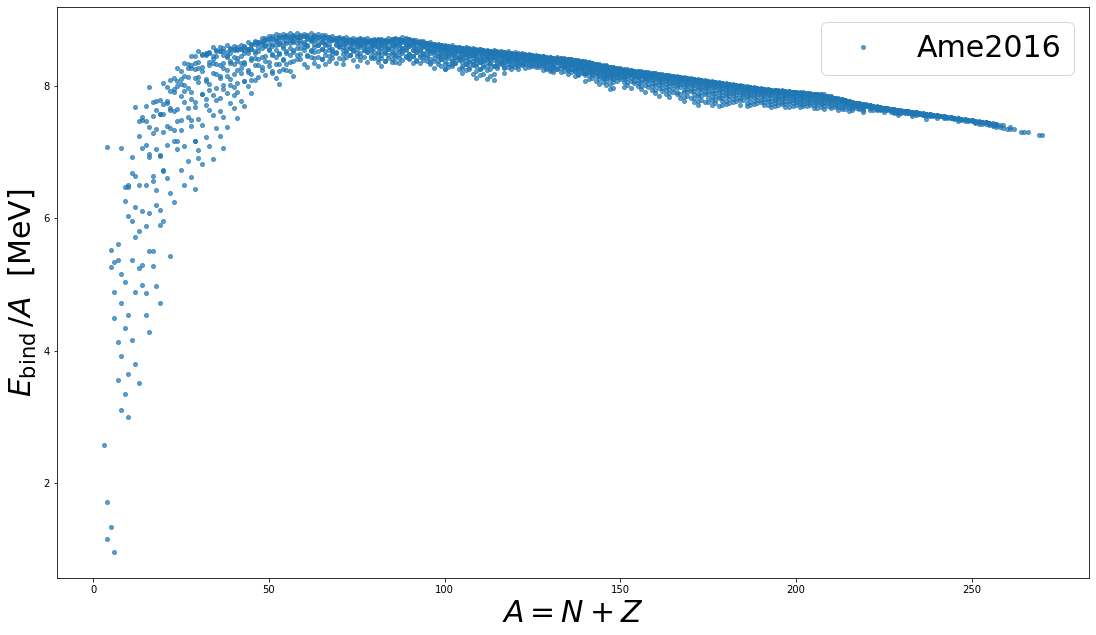

In [8]:
#Lets see how the data looks first


Masses['Eapprox']  = fity
# Generate a plot comparing the experimental with the fitted values values.
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel(r'$A = N + Z$',fontsize=30)
ax.set_ylabel(r'$E_\mathrm{bind}\,/A \ \ [\mathrm{MeV}]$',fontsize=30)

ax.plot(Masses['A'], Masses['Ebinding'],'o', alpha=0.7, markersize=4,
            label='Ame2016')


plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
ax.legend(fontsize=30)

save_fig("Masses2016")

plt.show()

Mean squared error: 0.02
Variance score: 0.96
Mean absolute error: 0.07
[14.01172846 13.28609536  0.57346032 16.98655754] 0.0


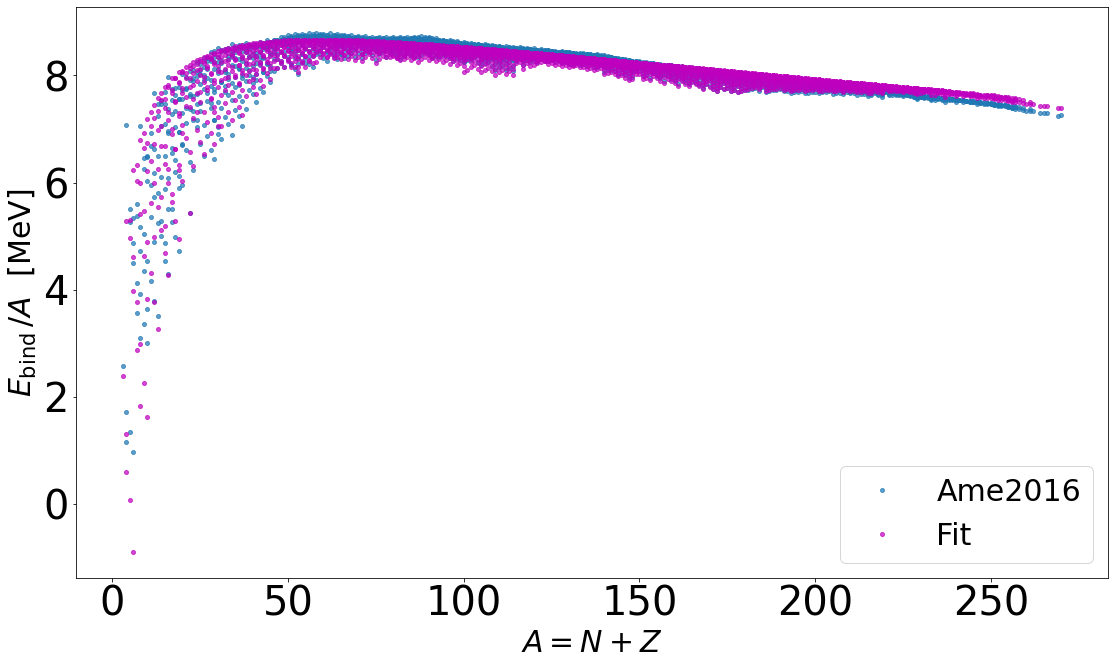

In [9]:
#And now how our fit looks, including quantities such as the mean squared error

# The mean squared error                               
print("Mean squared error: %.2f" % mean_squared_error(Energies, fity))
# Explained variance score: 1 is perfect prediction                                 
print('Variance score: %.2f' % r2_score(Energies, fity))
# Mean absolute error                                                           
print('Mean absolute error: %.2f' % mean_absolute_error(Energies, fity))
print(clf.coef_, clf.intercept_)


Masses['Eapprox']  = fity
# Generate a plot comparing the experimental with the fitted values values.
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel(r'$A = N + Z$',fontsize=30)
ax.set_ylabel(r'$E_\mathrm{bind}\,/A \ \ [\mathrm{MeV}]$',fontsize=30)
ax.plot(Masses['A'], Masses['Ebinding'], 'o', alpha=0.7, markersize=4,
            label='Ame2016')
ax.plot(Masses['A'], Masses['Eapprox'], 'o', alpha=0.7, markersize=4, c='m',
            label='Fit')

plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
ax.legend(fontsize=30)

save_fig("Masses2016")

plt.show()

# Now a challenge for you: add the paring term!